# Mismatch analysis tool

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
from shifting_baseline.data import load_data
from hydra import compose, initialize

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

# 加载数据
combined, uncertainties, history = load_data(cfg)
combined.head()

/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:213: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,0.296,0.519,-0.658,1.283
1001,-0.022,0.540,-0.956,1.078
1002,0.781,0.624,-0.434,1.937
1003,0.428,0.673,-0.889,1.641
1004,-0.221,0.654,-1.491,0.952


In [3]:
from shifting_baseline.filters import classify
from shifting_baseline.calibration import MismatchReport

# 校验数据
validation_data = pd.read_csv(cfg.ds.out.precip_z, index_col=0).iloc[:, 0]

# 数轮数据
tree_ring = combined["mean"]
mismatch_report = MismatchReport(
    pred=classify(validation_data),
    true=classify(tree_ring),
    value_series=tree_ring,
)
mismatch_report

MismatchReport(n_samples=113)

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

true,-2,-1,0,1,2
pred,,,,,
-2,NaN,0.096667,0.067571,NaN,NaN
-1,0.1355,NaN,-0.049333,0.03600,NaN
0,-0.4950,0.028636,NaN,-0.00875,NaN
1,NaN,0.006833,0.097071,NaN,NaN
2,NaN,-0.034000,0.268000,0.20760,NaN


<Axes: title={'center': 'False Estimation'}, xlabel='Natural data', ylabel='Historical data'>

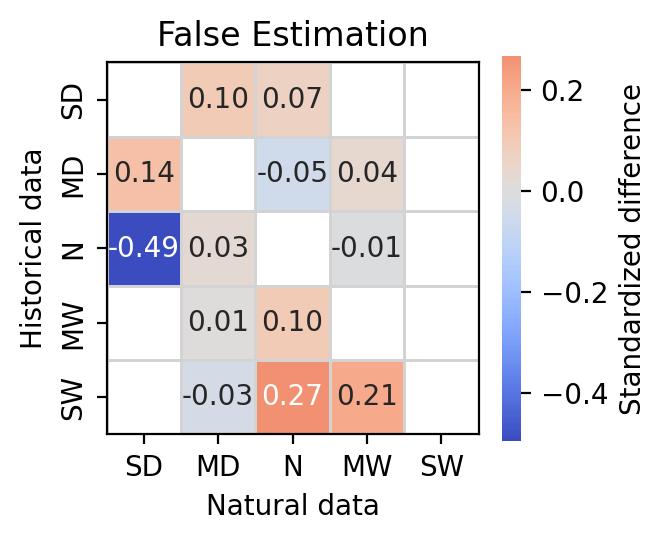

In [4]:
mismatch_report.analyze_error_patterns()
mismatch_report.plot_heatmap()

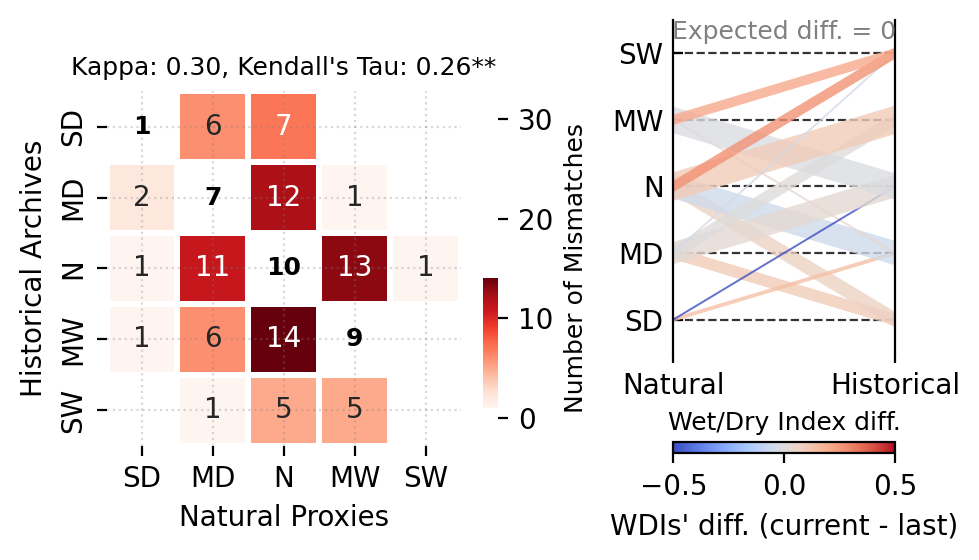

In [5]:
mismatch_report.generate_report_figure();

## 数轮+历史数据对比

In [6]:
history.setup()
pred, true = history.aggregate(
    how=cfg.agg_method,
    to_int=False,
    inplace=True,
).merge_with(
    combined["mean"],
    time_range="2-3",
    split=True,
)

mismatch_report = MismatchReport(
    pred=classify(pred, handle_na="skip"),
    true=classify(true, handle_na="skip"),
    value_series=pred,
)
mismatch_report
mismatch_report.analyze_error_patterns()

/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:213: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


MismatchReport(n_samples=208)

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

true,-2,-1,0,1,2
pred,,,,,
-2,NaN,NaN,NaN,NaN,NaN
-1,0.193587,NaN,-0.630534,-0.593390,NaN
0,NaN,0.139077,NaN,-0.295101,NaN
1,NaN,1.081148,0.387730,NaN,0.331622
2,NaN,NaN,NaN,NaN,NaN


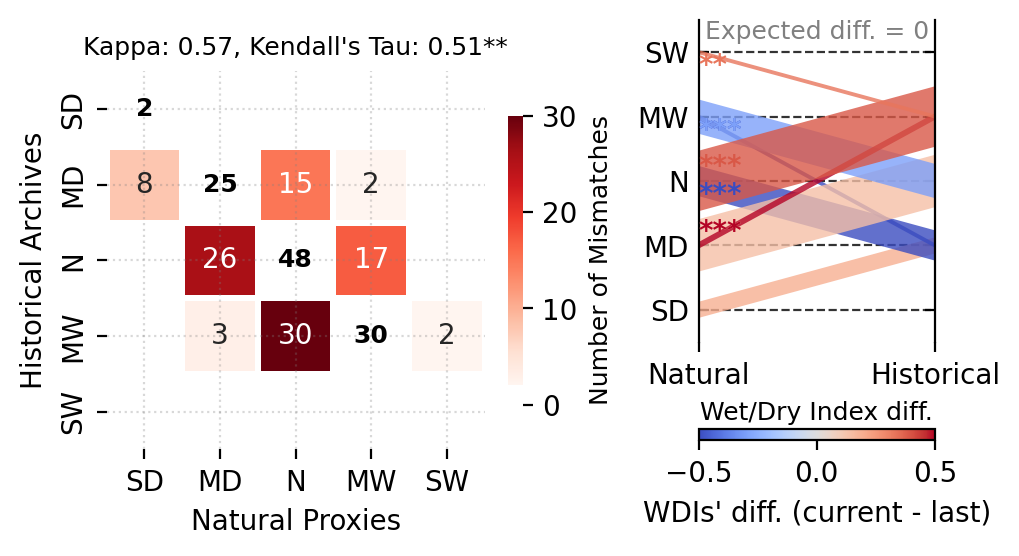

In [7]:
mismatch_report.generate_report_figure(figsize=(5.2, 3));

Figure 1. a: confusion matrix, showing the number of matched (diagonal, white colour) and mismatched (off-diagonal, red colour) judgments of extreme events between natural and recorded levels. b: mismatched between natural and recorded levels. The colour represents the standardised difference between natural and recorded levels. The line width represents the number of mismatches. The line colour represents the standardised difference between this judgement and the previous judgement at the same level. The line transparency represents the significance of the standardised difference (p < 0.05).

In [8]:
mismatch_report.diff_matrix.abs().mean().mean()

0.4177396649635902

In [9]:
mismatch_report.false_count_matrix.sum().sum()

103

### 测试不同的 shift

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

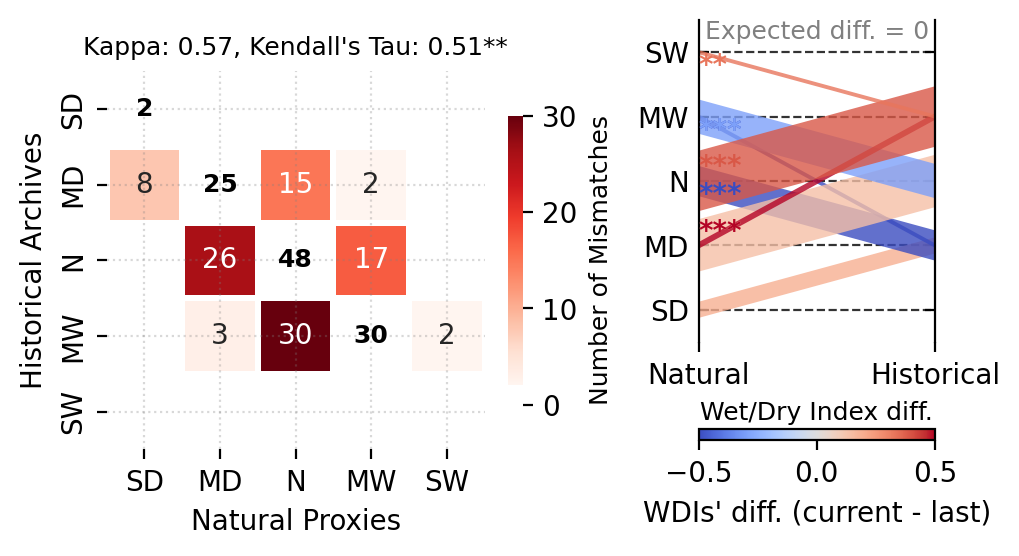

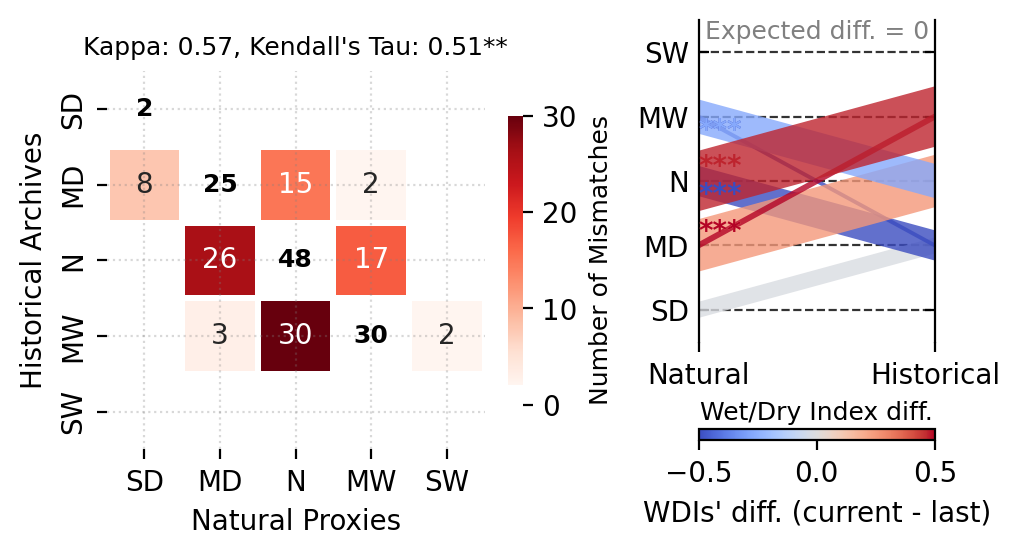

In [12]:
from matplotlib import pyplot as plt

for shift in range(1, 3):
    mismatch_report.analyze_error_patterns(shift=shift)
    mismatch_report.generate_report_figure(figsize=(5.2, 3))
plt.show();